In [1]:
import os
import sys
import torch

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

import domainbed.algorithms as algorithms
from domainbed.lib.fast_data_loader import InfiniteDataLoader, FastDataLoader
from domainbed import datasets
from types import SimpleNamespace
from domainbed.lib import misc


In [2]:
def load_model(model_dir, n_domains):
    dump = torch.load(os.path.join(model_dir, 'model.pkl'))
    algorithm_class = algorithms.get_algorithm_class(dump["args"]["algorithm"])
    algorithm = algorithm_class(
        dump["model_input_shape"],
        dump["model_num_classes"],
        n_domains,
        dump["model_hparams"])
    algorithm.load_state_dict(dump["model_dict"])
    return algorithm, dump['args'], dump['model_hparams']

def load_dataset(args, hparams):
    args = SimpleNamespace(**args)
    dataset = vars(datasets)[args.dataset](args.data_dir,
                args.test_envs, hparams)
    in_splits = []
    out_splits = []
    uda_splits = []
    val_envs = []
    ## Fill defaults to play nicely with wandb sweeps
    if args.dataset == 'PACS':
        if args.test_envs == None:
            args.test_envs = [0]
        if args.use_densenet == None:
            args.use_densenet = False
    elif args.dataset == 'WILDSCamelyon':
        if args.test_envs == None:
            args.test_envs = [2]
        if args.use_densenet == None:
            args.use_densenet = True
        ## For consistency with wilds benchmark, env 1 should be only used as OOD val dataset
        val_envs.append(1)
    for env_i, env in enumerate(dataset):
        uda = []

        out, in_ = misc.split_dataset(env,
            int(len(env)*args.holdout_fraction),
            misc.seed_hash(args.trial_seed, env_i))

        if env_i in args.test_envs:
            uda, in_ = misc.split_dataset(in_,
                int(len(in_)*args.uda_holdout_fraction),
                misc.seed_hash(args.trial_seed, env_i))

        if hparams['class_balanced']:
            in_weights = misc.make_weights_for_balanced_classes(in_)
            out_weights = misc.make_weights_for_balanced_classes(out)
            if uda is not None:
                uda_weights = misc.make_weights_for_balanced_classes(uda)
        else:
            in_weights, out_weights, uda_weights = None, None, None
        in_splits.append((in_, in_weights))
        out_splits.append((out, out_weights))
        if len(uda):
            uda_splits.append((uda, uda_weights))

    if args.task == "domain_adaptation" and len(uda_splits) == 0:
        raise ValueError("Not enough unlabeled samples for domain adaptation.")

    eval_loaders = [torch.utils.data.DataLoader(
        dataset=env,
        shuffle=False,
        batch_size=64,
        num_workers=4)
        for env, _ in (in_splits + out_splits + uda_splits)]
    eval_weights = [None for _, weights in (in_splits + out_splits + uda_splits)]
    eval_loader_names = ['env{}_in'.format(i)
        for i in range(len(in_splits))]
    eval_loader_names += ['env{}_out'.format(i)
        for i in range(len(out_splits))]
    eval_loader_names += ['env{}_uda'.format(i)
        for i in range(len(uda_splits))]
    loader_dict = {}
    for i in range(len(eval_loaders)):
        loader_dict[eval_loader_names[i]] = eval_loaders[i]
    return loader_dict

    

In [3]:
model, args, hparams = load_model('/network/scratch/o/omar.salemohamed/domainbed/output/f1d7349d-b853-46dd-96d7-0a3326fe90b2', n_domains=3)
model.eval()

/home/mila/o/omar.salemohamed/.conda/envs/wilds/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mila/o/omar.salemohamed/.conda/envs/wilds/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DANN(
  (featurizer): DenseNet121(
    (network): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(


In [14]:
loaders = load_dataset(args, hparams)
print(loaders.keys())

dict_keys(['env0_in', 'env1_in', 'env2_in', 'env3_in', 'env4_in', 'env0_out', 'env1_out', 'env2_out', 'env3_out', 'env4_out'])


In [21]:
def gather_activations(dataloader, model, feature_dim, N, K):
    """
    Collect N activations for each class from the model.

    :param dataloader: PyTorch dataloader
    :param model: Your trained model
    :param feature_dim: dimension of the feature/activation from the model
    :param N: number of samples you want for each class
    :param K: number of classes
    :return: Tensor of size [K, N, feature_dim]
    """

    # Store the activations here
    activations_tensor = torch.zeros([K, N, feature_dim])

    # Counters to keep track of how many samples we've seen for each label
    counters = {k: 0 for k in range(K)}

    # Ensure the model is in eval mode
    model.eval()

    with torch.no_grad():
        for x, y in dataloader:
            # Get activations
            activations = model.featurizer(x)

            # For each label in the batch
            for i in range(y.size(0)):
                label = y[i].item()

                # Check if we've already seen enough samples for this label
                if counters[label] < N:
                    activations_tensor[label, counters[label]] = activations[i]
                    counters[label] += 1

            # Check if we've collected enough samples for all labels
            if all([count >= N for count in counters.values()]):
                break

    return activations_tensor

In [25]:
N = 200
d = 1024
data_shape = (3, 224, 224)
all_features = torch.zeros(5, 2, N, d)

for env_id in range(5):
    loader = loaders[f'env{env_id}_out']
    # all_features[env_id] = gather_activations(loader, model, d, N, 2)
    for x, y in loader:
        features = model.featurizer(x)
        ortho = get_orthogonal_complement(p, features)
        print(ortho.shape)
        # for label in [0, 1]:
            # all_features[env_id, label] = features[y==label][:N].detach().cpu()
        break
    break
            


torch.Size([64, 1024])


In [44]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
pca = PCA()
pca_feats = pca.fit_transform(all_features.flatten(end_dim=-2))
pca_feats = pca_feats.reshape(5, 2, N, pca_feats.shape[-1])
pca_feats = pca_feats[:, :, :, :2]
print(pca_feats.shape)
df_data = []
for env_id in range(5):
    for label in [0, 1]:
        for n in range(N):
            df_data.append([env_id, label, n, pca_feats[env_id, label, n, 0], pca_feats[env_id, label, n, 1]])
df = pd.DataFrame(df_data, columns = ['env', 'label', 'n', 'pc_0', 'pc_1'])
df['env'] = df['env'].astype(str)


(5, 2, 200, 2)


In [48]:
from pathlib import Path
import pandas as pd
df_dir = Path('./dfs/')
dfs = []
for f in df_dir.iterdir():
    if 'feats' in f.name:
        print(f.name)
        dfs.append(pd.read_pickle(f))
df = pd.concat(dfs, ignore_index=True)
def set_domain_type(x):
    if x in [0, 3, 4]:
        return 'train'
    elif x == 1:
        return 'val'
    elif x == 2:
        return 'test'

def set_model_name(r):
    if r['task'] == 'domain_adaptation':
        prefix = 'UDA'
    else:
        prefix = 'DG'
    return f'{prefix}_λ={r["dann_lambda"]}'


# Apply the function to the existing column to create the new column
df['domain'] = df['env'].apply(set_domain_type)
df['env'] = df['env'].astype(str)
df['model_name'] = df.apply(set_model_name, axis=1)
# df['domain_class'] = df['domain'] + '_' + df['']


feats_62b8f706-cb03-4bf2-8540-6c9efccae1fb.pk
feats_615414d7-9de2-49a2-b1e7-1b002ac96c42.pk
feats_d29bfe0a-d014-41c4-8fb3-6a355a0ce84e.pk


In [23]:
df.env.unique()

array(['0', '1', '2', '3', '4'], dtype=object)

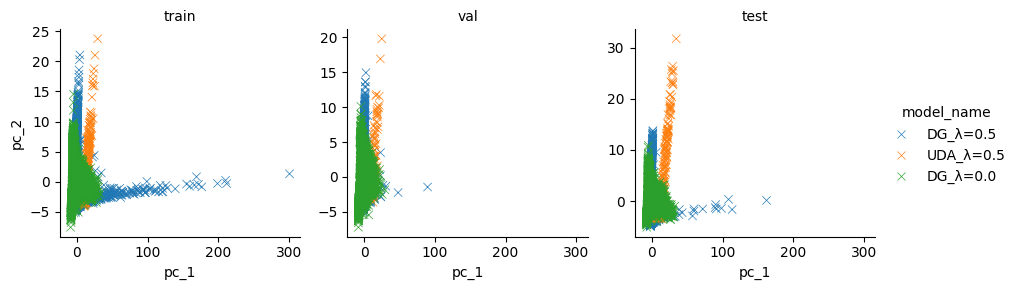

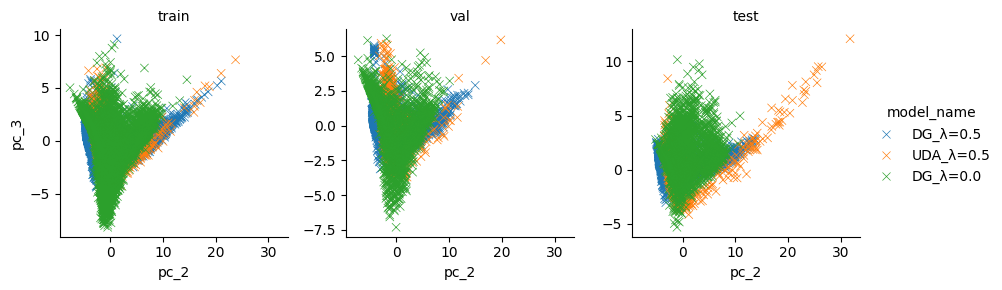

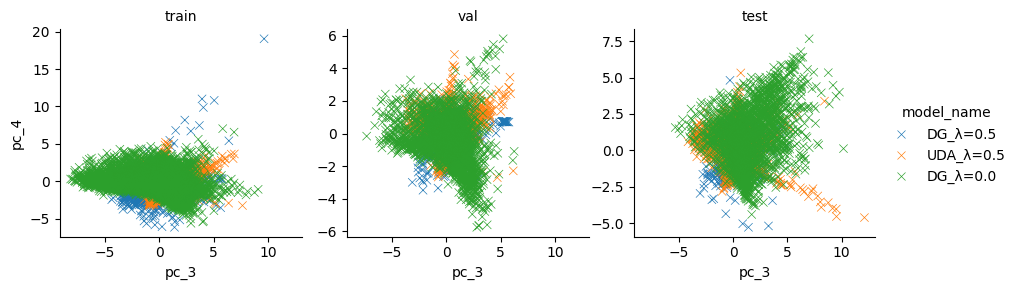

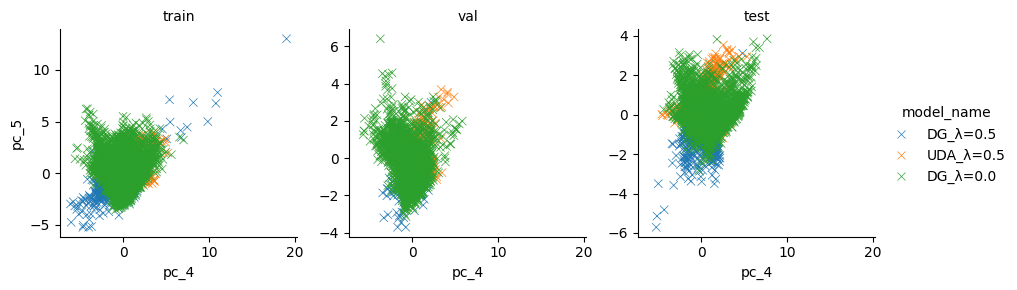

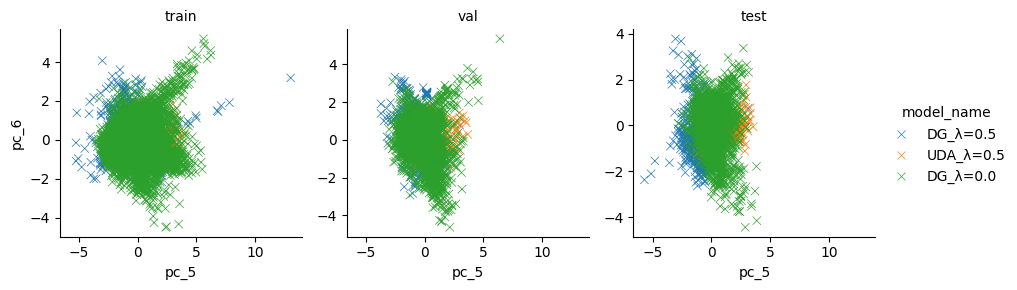

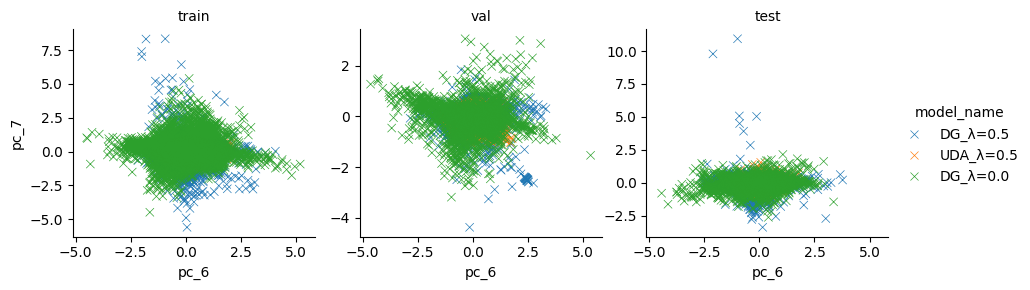

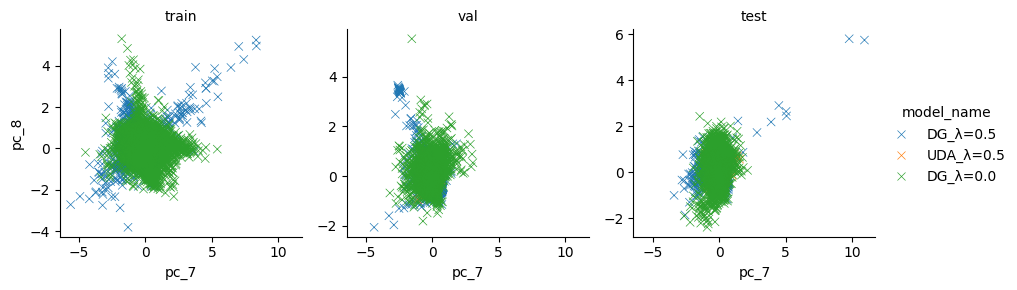

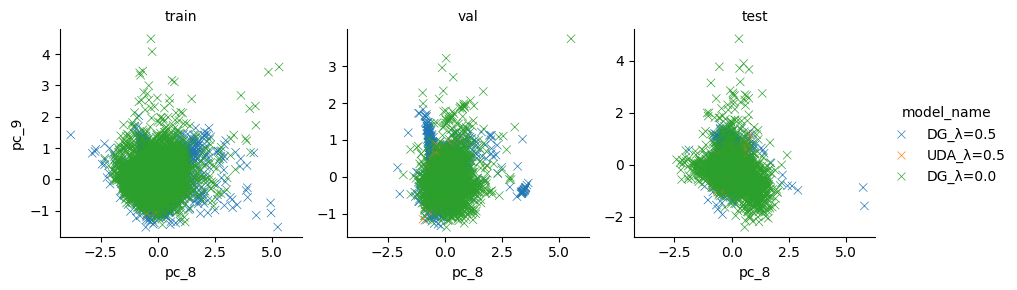

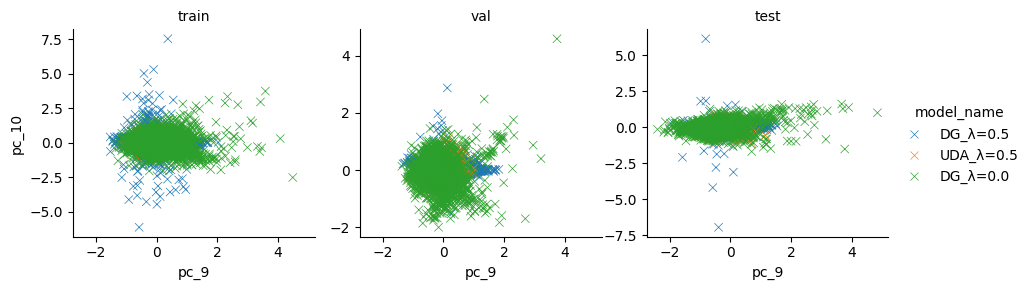

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
# sns.scatterplot(data=df.query(), x='pc_1', y='pc_2', hue='label', alpha=1)
# palette = {f'{i}': 'orange' for i in range(5)}
# palette['2'] = 'blue'
hue = 'domain'
c_order = sorted(df['model_name'].unique())
# df = df.query('n <= 50')
# for i in range(1, 10):
#     # for j in range(i + 1, 10):
#     g = sns.FacetGrid(df, col='model_name', sharey=False, col_order=c_order)
#     g.map_dataframe(sns.scatterplot, x=f'pc_{i}', y=f'pc_{i + 1}', hue=hue, alpha=1, marker='x')
#     g.set_titles(size=10, col_template="{col_name}", row_template="{row_name}")
#     g.add_legend(title=f'{hue}')
#     plt.show()
# for i in range(1, 10):
#     # for j in range(i + 1, 10):
#     g = sns.FacetGrid(df, col='model_name', row='label', sharey=False, col_order=c_order)
#     g.map_dataframe(sns.scatterplot, x=f'pc_{i}', y=f'pc_{i + 1}', hue=hue, alpha=1, marker='x')
#     g.set_titles(size=10, col_template="{col_name}", row_template="{row_name}")
#     g.add_legend(title=f'{hue}')
#     plt.show()

# for i in range(1, 10):
#     # for j in range(i + 1, 10):
#     g = sns.FacetGrid(df, col='model_name', row='domain', sharey=False, col_order=c_order)
#     g.map_dataframe(sns.scatterplot, x=f'pc_{i}', y=f'pc_{i + 1}', hue='label', alpha=1, marker='x')
#     g.set_titles(size=10, col_template="{col_name}", row_template="{row_name}")
#     g.add_legend(title=f'label')
#     plt.show()

for i in range(1, 10):
    # for j in range(i + 1, 10):
    g = sns.FacetGrid(df, col='domain', sharey=False)
    g.map_dataframe(sns.scatterplot, x=f'pc_{i}', y=f'pc_{i + 1}', hue='model_name', alpha=1, marker='x')
    g.set_titles(size=10, col_template="{col_name}", row_template="{row_name}")
    g.add_legend(title=f'model_name')
    plt.show()


In [42]:
for x, y in loaders['env2_out']:
    features = model.featurizer(x)
    print(features.shape)
    break

torch.Size([64, 1024])


In [ ]:
for x, y in loaders['env2_out']:
    preds = model.predict(x)
    acc = (preds.argmax(dim=1) == y).float().mean().item()
    print(acc)
    break